Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                      
import matplotlib.pyplot as plt             
%matplotlib inline     
sns.set(color_codes=True)

In [ ]:
df_city_bikes = pd.read_csv('citybikes_PL.csv')
df_foursquare = pd.read_csv('foursquare.csv')
df_yelp = pd.read_csv('yelp.csv')
#joining on a composite key of columns 'bike_station_location','name','address' inorder to get a unique key to join on
df_first_join = pd.merge(df_yelp, df_foursquare, on=['bike_station_location','name','address'], how='inner')
df_final_join = pd.merge(df_first_join, df_city_bikes, on='bike_station_location', how='left')
df_final_join

In [ ]:
bike_station_location	name	main_category_x	address	price	rating	review_count	status	distance_away_x	main_category_y	distance_away_y	latitude	longitude	num_of_bikes
0	45.51195046,-122.6141596	Apizza Scholls	Pizza	4741 SE Hawthorne Blvd	$$	4.0	1735	Open	82.518277	Pizzeria	82	45.511950	-122.614160	3
1	45.51195046,-122.6141596	Sapphire Hotel	Lounges	5008 SE Hawthorne Blvd	$$	4.5	487	Open	225.793673	Cocktail Bar	216	45.511950	-122.614160	3
2	45.51195046,-122.6141596	East Side Delicatessen	Delis	4626 SE Hawthorne Blvd	$	4.0	408	Open	33.461068	Deli	28	45.511950	-122.614160	3
3	45.51195046,-122.6141596	Zach's Shack	Fast Food	4611 SE Hawthorne Blvd	$	3.5	270	Open	58.987619	Hot Dog Joint	55	45.511950	-122.614160	3
4	45.54827571,-122.6111636	Noho's Hawaiian Cafe	Hawaiian	4627 NE Fremont St	$$	4.0	374	Open	340.597357	Café	342	45.548276	-122.611164	6
...	...	...	...	...	...	...	...	...	...	...	...	...	...	...
577	45.5965621,-122.7478995	Homegrown Smoker	Vegan	8638 N Lombard St	$$	4.5	703	Open	896.491052	BBQ Joint	894	45.596562	-122.747900	9
578	45.5965621,-122.7478995	Leisure Public House	Pubs	8002 N Lombard St	$	4.5	235	Open	829.466752	Bar	824	45.596562	-122.747900	9
579	45.5965621,-122.7478995	Thai Cottage	Thai	8620 N Lombard St	$$	3.5	256	Open	905.682509	Thai Restaurant	900	45.596562	-122.747900	9
580	45.5178988,-122.6600522	Hat Yai	Thai	605 SE Belmont St	$$	4.0	238	Open	141.103916	Thai Restaurant	146	45.517899	-122.660052	10
581	45.5178988,-122.6600522	Rum Club	American (New)	720 SE Sandy Blvd	$$	4.0	286	Open	202.268601	Cocktail Bar	211	45.517899	-122.660052	10

582 rows × 14 columns

In [ ]:
# The combined dataframe was refined by excluding unnecessary columns (retained main_category_y due to its potential for more precise category combinations, and latitude and longitude were also retained for potential future analysis). The presence of NaN values was examined and rows containing such values were retained, as other data in those rows might influence the statistical model.
# Duplicate rows were reviewed and removed, and an assessment was made for any outlier values. For instance, only distance values beyond the 1000m radius were deemed outliers, as we aim to exclude data beyond this radius from our statistical model.
df_final_join.isnull().sum()

bike_station_location     0
name                      0
main_category_x           0
address                   0
price                    20
rating                    0
review_count              0
status                    0
distance_away_x           0
main_category_y           0
distance_away_y           0
latitude                  0
longitude                 0
num_of_bikes              0
dtype: int64

In [ ]:
#this results shows that there at 0 duplicated rows, so nothing was dropped
df_final_join.duplicated().sum()

In [ ]:
#checking to see if there are any outliers in the distance col, since these are the only outliers
#that would be good to remove from the dataset since we only want data within 1000m
sns.boxplot(x=df_final_cleaned['distance_away_x'])
print(np.where((df_final_cleaned['distance_away_x']>1000) & (df_final_cleaned['distance_away_x']<0)))
#this shows that there are no distance values > 1000m

![Alt text](image.png)

In [ ]:
df_final_cleaned = df_final_join.drop(['distance_away_y'], axis=1)
df_final_cleaned

In [ ]:
bike_station_location	name	main_category_x	address	price	rating	review_count	status	distance_away_x	main_category_y	latitude	longitude	num_of_bikes
0	45.51195046,-122.6141596	Apizza Scholls	Pizza	4741 SE Hawthorne Blvd	$$	4.0	1735	Open	82.518277	Pizzeria	45.511950	-122.614160	3
1	45.51195046,-122.6141596	Sapphire Hotel	Lounges	5008 SE Hawthorne Blvd	$$	4.5	487	Open	225.793673	Cocktail Bar	45.511950	-122.614160	3
2	45.51195046,-122.6141596	East Side Delicatessen	Delis	4626 SE Hawthorne Blvd	$	4.0	408	Open	33.461068	Deli	45.511950	-122.614160	3
3	45.51195046,-122.6141596	Zach's Shack	Fast Food	4611 SE Hawthorne Blvd	$	3.5	270	Open	58.987619	Hot Dog Joint	45.511950	-122.614160	3
4	45.54827571,-122.6111636	Noho's Hawaiian Cafe	Hawaiian	4627 NE Fremont St	$$	4.0	374	Open	340.597357	Café	45.548276	-122.611164	6
...	...	...	...	...	...	...	...	...	...	...	...	...	...
577	45.5965621,-122.7478995	Homegrown Smoker	Vegan	8638 N Lombard St	$$	4.5	703	Open	896.491052	BBQ Joint	45.596562	-122.747900	9
578	45.5965621,-122.7478995	Leisure Public House	Pubs	8002 N Lombard St	$	4.5	235	Open	829.466752	Bar	45.596562	-122.747900	9
579	45.5965621,-122.7478995	Thai Cottage	Thai	8620 N Lombard St	$$	3.5	256	Open	905.682509	Thai Restaurant	45.596562	-122.747900	9
580	45.5178988,-122.6600522	Hat Yai	Thai	605 SE Belmont St	$$	4.0	238	Open	141.103916	Thai Restaurant	45.517899	-122.660052	10
581	45.5178988,-122.6600522	Rum Club	American (New)	720 SE Sandy Blvd	$$	4.0	286	Open	202.268601	Cocktail Bar	45.517899	-122.660052	10

582 rows × 13 columns

In [ ]:
#exporting to csv file for future use
df_final_cleaned.to_csv('joined_data.csv', index=False)

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [ ]:
# The boxplot reveals a handful of distances that qualify as outliers according to our dataset's distribution, yet none of these distances surpass 1000 meters. Given that our dataset is intended to encompass all distances up to 1000 meters, these outliers were retained.
sns.boxplot(x=df_final_cleaned['distance_away_x'])

<Axes: xlabel='distance_away_x'>

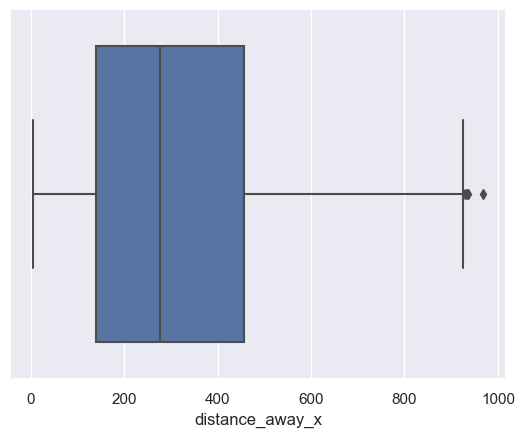

In [ ]:

# Upon analyzing the scatter plot depicting the relationship between distance away and review count, the initial insight gleaned from this visualization 
# is that places in closer proximity to bike stations tend to exhibit higher review counts, aligning with our expectations.
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_final_cleaned['distance_away_x'], df_final_cleaned['review_count'])
ax.set_xlabel('distance_away')
ax.set_ylabel('review_count')
plt.show()

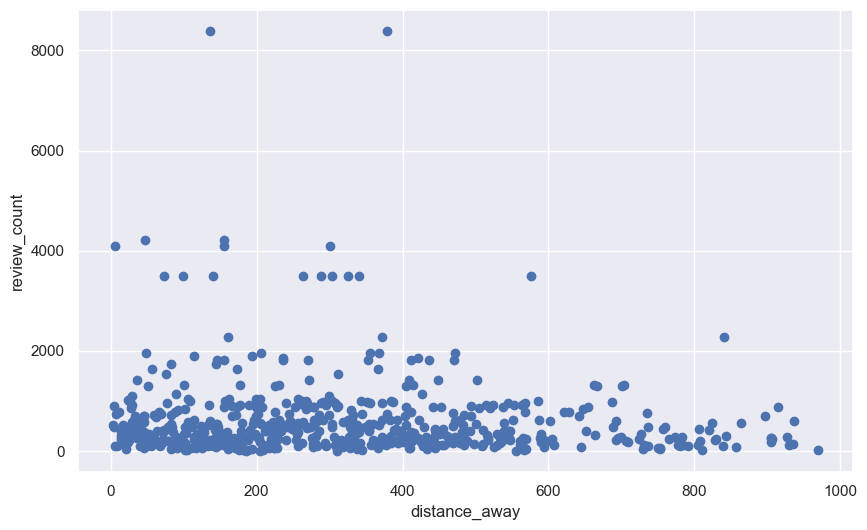

In [ ]:
# Upon examining the scatter plot illustrating the correlation between total potential bikes and review count, the preliminary observation derived from this visualization is that there appears to be no discernible pattern or connection between the total potential bikes available at a station 
# and the volume of reviews received by a business located within a 1000-meter radius of the bike station.
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_final_cleaned['num_of_bikes'], df_final_cleaned['review_count'])
ax.set_xlabel('num_of_bikes')
ax.set_ylabel('review_count')
plt.show()

![Alt text](image-1.png)

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [ ]:
import sqlite3
from sqlite3 import Error

def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [ ]:
connection = create_connection("../data/city_bike_POI.sqlite")

Connection to SQLite DB successful

In [ ]:
create_city_bikes_portland_table = """
CREATE TABLE IF NOT EXISTS city_bikes_portland (
  bike_station_location TEXT,
  latitude FLOAT,
  longitude FLOAT,
  num_of_bikes INTEGER
);
"""

In [ ]:
conn = sqlite3.connect("../data/city_bike_POI.sqlite")
c = conn.cursor()

In [ ]:
c.execute(create_city_bikes_portland_table)

In [ ]:
df_city_bikes.to_sql('city_bikes_portland', conn, if_exists='replace', index=False)

236

In [ ]:
create_foursquare_table = """
CREATE TABLE IF NOT EXISTS foursquare (
  bike_station_location TEXT,
  name TEXT,
  main_category TEXT,
  address TEXT,
  distance_away INTEGER
);
"""

In [ ]:
c.execute(create_foursquare_table)

In [ ]:
df_foursquare.to_sql('foursquare', conn, if_exists='replace', index=False)

2353

In [ ]:
#c.execute("""SELECT * FROM foursquare""")
#c.fetchall()
create_yelp_table = """
CREATE TABLE IF NOT EXISTS yelp (
  bike_station_location TEXT,
  name TEXT,
  main_category TEXT,
  address TEXT,
  price TEXT,
  rating FLOAT,
  review_count INTEGER,
  status TEXT,
  distance_away FLOAT
);
"""

In [ ]:
c.execute(create_yelp_table)

In [ ]:
df_yelp.to_sql('yelp', conn, if_exists='replace', index=False)

4715

In [ ]:
create_joined_table = """
CREATE TABLE IF NOT EXISTS joined (
  bike_station_location TEXT,
  name TEXT,
  main_category_x TEXT,
  address TEXT,
  price TEXT,
  rating FLOAT,
  review_count INTEGER,
  status TEXT,
  distance_away_x FLOAT,
  main_category_y TEXT,
  latitude FLOAT,
  longitude FLOAT,
  num_of_bikes INTEGER
);
"""

In [ ]:
c.execute(create_joined_table)

In [ ]:
df_final_cleaned.to_sql('joined', conn, if_exists='replace', index=False)

582

In [ ]:
#checking to see if data was inserted correctly
c.execute("""SELECT * FROM joined""")
c.fetchall()

Look at the data before and after the join to validate your data.

In [ ]:
#checking to see if NaN values exist in the data before and after joining
print(df_final_cleaned.isnull().values.any(), df_city_bikes.isnull().values.any(), df_foursquare.isnull().values.any(),
      df_yelp.isnull().values.any())


True False True True

In [ ]:
#checking to see if there are any duplicate rows in our resulting joined data
df_final_cleaned.duplicated().values.any()


False

In [ ]:
#checking to see if the number of rows in the data after joining is less than the rows from the 2 tables joined with 
#the composite key
print(df_foursquare.shape, df_yelp.shape, df_final_cleaned.shape)


(2353, 5) (4715, 9) (582, 13)